""" Author: Halsay
    Reference: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    Date: 2020-11-25
    <MFCC Tutorial>
    We will give a high level intro to the implementation steps, then go in depth how to implement. 
    Towards the end we will go into a more detailed description of how to calculate MFCCs:

    1. Frame the signal into short frames.
    2. For each frame calculate the periodogram estimate of the power spectrum.
    3. Apply the mel filterbank to the power spectrum, sum the energy in each filter.
    4. Take the logarithm of all filterbank energies.
    5. Take the DCT of the log filterbank energies.
    6. Keep DCT coefficients 2-13, discard the rest.
"""

## 1. Frame the signal into short frames.

In [51]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [52]:
fs, wavdata = wavfile.read("./wave/test.wav") # read a wav file into numpy array
print(fs, wavdata.shape) # print frequency and sample count (sample count = frequency * wav length)

8000 (14476,)


In [53]:
# 采样频率
fs

8000

In [54]:
# 采样数据
wavdata

array([-5, -5, -5, ..., -6, -6, -2], dtype=int16)

In [55]:
len(wavdata)/(fs)

1.8095

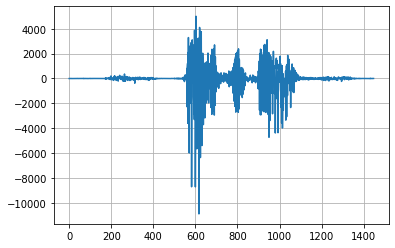

In [56]:
y = wavdata[::10]
plt.plot(y)
plt.grid()
plt.show()

In [57]:
frame_len = 25 # each frame length (ms)
frame_shift = 10 # frame shift length (ms)
frame_len_samples = frame_len*fs//1000 # each frame length (samples)
frame_shift_samples = frame_shift*fs//1000 # frame shifte length (samples)

total_frames = int(np.ceil((len(wavdata) - frame_len_samples)/float(frame_shift_samples)) + 1) # total frames will get
padding_length = int((total_frames - 1)*frame_shift_samples + frame_len_samples - len(wavdata)) # how many samples last frame need to pad
pad_data = np.pad(wavdata,(0,padding_length),mode='constant') # pad last frame with zeros

In [61]:
total_frames

180

In [62]:
padding_length

44

In [63]:
frame_len_samples

200

In [64]:
frame_shift_samples

80

In [65]:
total_frames

180

In [66]:
""" when we frame the signal, usually we do Pre-emphasis first to amplify high frequency signals.
    Pre-emphasis function:
        y(n) = x(x)-a*x(x-1)  
    The reason why we do Pre-emphasis please watch reference: https://zhuanlan.zhihu.com/p/34798429
    Also, we often add a window function to the frame to reduce signal discontinuity at the beginning and end of the frame.
    There are many window functions, we use hamming window here as an example.
"""
frame_data = np.zeros((total_frames,frame_len_samples)) # where we save the frame results
pre_emphasis_coeff = 0.97 # Pre-emphasis coefficient
window_func = np.hamming(frame_len_samples) # hamming window
pad_data = np.append(pad_data[0],pad_data[1:]-pre_emphasis_coeff*pad_data[:-1]) # Pre-emphasis

for i in range(total_frames):
    single_frame = pad_data[i*frame_shift_samples:i*frame_shift_samples+frame_len_samples] # original frame data
    single_frame = single_frame * window_func # add window function
    frame_data[i,:] = single_frame

In [67]:
len(window_func)

200

In [68]:
frame_data.shape

(180, 200)

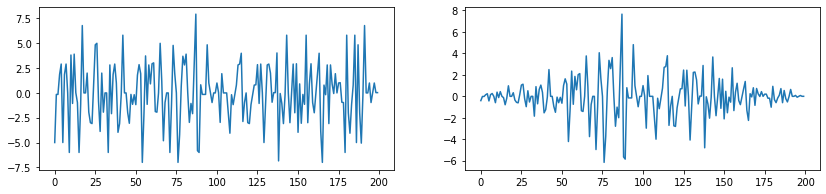

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
ax[0].plot(pad_data[:200])
ax[1].plot(frame_data[0])
plt.show()

## 2. For each frame calculate the periodogram estimate of the power spectrum.

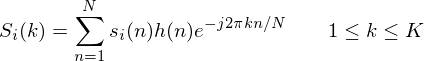

In [70]:
""" `
    To transform the frame data from time-domain to frequency-domain we take the Discrete Fourier Transform (DFT) of the frame, 
    by perform the following function:
"""
from IPython.display import Image
Image("./img/DFT.png")

In [76]:
""" where si(n) is the frame data and h(n) is the window function, K is the length of DFT (usually 256 or 512).
    The periodogram-based power spectral estimate for the speech frame si(n) is given by:
"""

' where si(n) is the frame data and h(n) is the window function, K is the length of DFT (usually 256 or 512).\n    The periodogram-based power spectral estimate for the speech frame si(n) is given by:\n'

In [73]:
K = 512 # length of DFT
freq_domain_data = np.fft.rfft(frame_data,K) # DFT
power_spec = np.absolute(freq_domain_data) ** 2 * (1/K) # power spectrum

In [91]:
freq_domain_data.shape

(180, 257)

In [86]:
np.fft.fft([0, 1, 0, 0])
# ar0ray([ 1.+0.j,  0.-1.j, -1.+0.j,  0.+1.j]) # may vary 
np.fft.rfft([0, 1, 0, 0])
# array([ 1.+0.j,  0.-1.j, -1.+0.j]) # may vary

array([ 1.+0.j,  0.-1.j, -1.+0.j])

/home/gavin/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


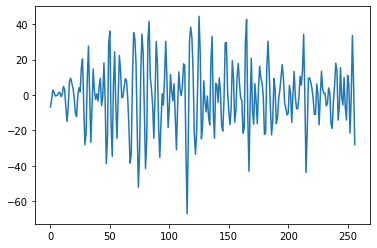

In [89]:
plt.plot(freq_domain_data[0])

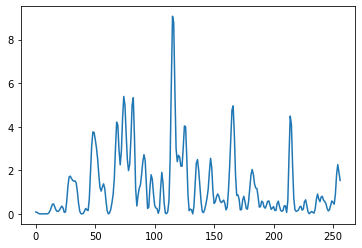

In [88]:
plt.plot(power_spec[0])

In [92]:
""" 3. Apply the mel filterbank to the power spectrum, sum the energy in each filter.
    The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. 
    Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. 
    Incorporating this scale makes our features match more closely what humans hear.
    The formula for converting from frequency to Mel scale is:
        M(f) = 2595*log10(1+f/700)
    And formula for converting from Mel scale to frequency is:
        F(m) = 700*(10**(m/2595)-1)
"""
low_frequency = 20 # We don't use start from 0 Hz because human ear is not able to perceive low frequency signal.
high_frequency = fs//2 # if the speech is sampled at f Hz then our upper frequency is limited to 2/f Hz.
low_frequency_mel = 2595 * np.log10(1 + low_frequency / 700)
high_frequency_mel = 2595 * np.log10(1 + high_frequency / 700)
n_filt = 40 # number of mel-filters (usually between 22-40)
mel_points = np.linspace(low_frequency_mel, high_frequency_mel, n_filt + 2) # Make the Mel scale spacing equal.
hz_points = (700 * (10**(mel_points / 2595) - 1)) # convert back to Hz scale.
bins = np.floor((K + 1) * hz_points / fs) # round those frequencies to the nearest FFT bin.

In [94]:
bins

array([  1.,   3.,   5.,   8.,  10.,  13.,  15.,  18.,  21.,  24.,  28.,
        31.,  35.,  38.,  42.,  46.,  51.,  55.,  60.,  65.,  70.,  75.,
        81.,  87.,  93., 100., 106., 113., 121., 129., 137., 145., 154.,
       164., 173., 184., 194., 206., 217., 230., 243., 256.])

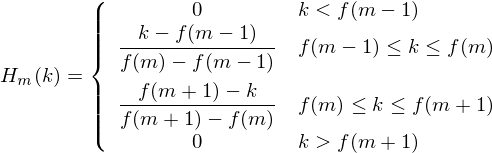

In [28]:
"""Now we create our filterbanks. 
    The first filterbank will start at the first point, reach its peak at the second point, then return to zero at the 3rd point. 
    The second filterbank will start at the 2nd point, reach its max at the 3rd, then be zero at the 4th etc. 
    A formula for calculating these is as follows:
"""
Image("./img/fbank.png")

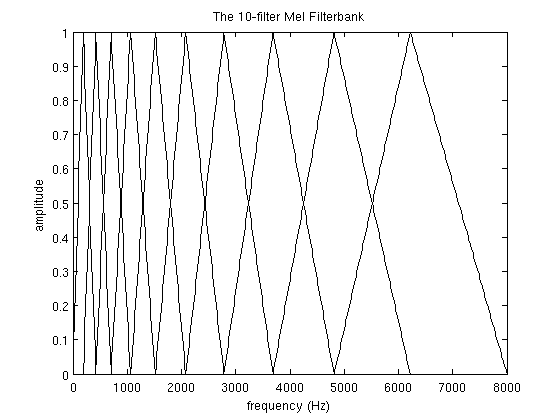

In [29]:
"""The filterbanks are triangle filters, they should look like above figure:
"""
Image("./img/mel_tri.png")

In [95]:
fbank = np.zeros((n_filt, int(np.floor(K / 2 + 1))))
for m in range(1, n_filt + 1):
    f_m_minus = int(bins[m - 1])   # left point
    f_m = int(bins[m])             # peak point
    f_m_plus = int(bins[m + 1])    # right point

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
filter_bank = np.matmul(power_spec,fbank.T) # This is known as fbank feature.
filter_bank = np.where(filter_bank == 0,np.finfo(float).eps,filter_bank) # Repalce 0 to a small constant or it will cause problem to log.

In [100]:
power_spec.shape

(180, 257)

In [97]:
fbank.shape

(40, 257)

In [98]:
filter_bank.shape

(180, 40)

In [31]:
"""4. Take the logarithm of all filterbank energies.
"""
log_fbank = np.log(filter_bank) # We can also use log_fbank = 20*np.log10(filter_bank) to get dB energies.

In [32]:
""" 5. Take the DCT of the log filterbank energies.
    6. Keep DCT coefficients 2-13, discard the rest.
"""
from scipy.fftpack import dct
num_ceps = 12 # MFCC feature dims, usually between 2-13.
# feature from other dims are dropped beacuse they represent rapid changes in filter bank coefficients and they are not helpful for speech models.
mfcc = dct(log_fbank, type=2, axis=1, norm="ortho")[:, 1 : (num_ceps + 1)] 

## Reference 
[什么是汉明窗？加Hanmming窗的作用？](https://blog.csdn.net/weixin_42788078/article/details/89278710)  
[语音识别之特征提取](https://zhuanlan.zhihu.com/p/147386972)